In [47]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.stats import norm
import pprint as pp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [48]:
#Export stock ticker as list
df = pd.read_csv("ESG 30 stocks.csv", index_col=0)

TICKERS = df['Symbol'].tolist()
TICKERS.sort()
START_DATE = '2017-01-01'
END_DATE = '2022-01-01'

# data1 = data.DataReader(tickers,'yahoo', start_date, end_date)

prices_df = yf.download(TICKERS, start=START_DATE, 
                        end=END_DATE, adjusted=True)

adj_close_df = prices_df['Adj Close']

[*********************100%***********************]  30 of 30 completed


In [58]:
N_DAYS=252
N_ASSETS = len(TICKERS)
N_SIMULATION = 10**7

In [56]:
returns_df = adj_close_df.pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [59]:
#Prepare weights
np.random.seed(0)
weights = np.random.random(size=(N_SIMULATION, N_ASSETS))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

#Calculate portfolio returns
portf_rtns = np.dot(weights, avg_returns)

#Calculate portfolio volatility
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  

#Calculate Sharpe Ratio
portf_sharpe_ratio = portf_rtns / portf_vol

#Create a dataframe to store the results
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [29]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

In [30]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [31]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(TICKERS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 35.59% volatility: 24.16% sharpe_ratio: 147.34% 
Weights
AAPL: 7.26% ACN: 0.57% AMP: 0.25% AMT: 3.25% ARE: 0.76% ASGN: 5.68% ASIX: 5.26% BCO: 0.08% CBT: 1.59% CC: 1.31% CDNS: 10.03% CRM: 1.10% EBAY: 6.86% FIVE: 1.93% FN: 6.29% FR: 2.71% FTNT: 7.95% HOLX: 0.07% JBHT: 1.63% KIM: 0.43% MATX: 6.50% MHK: 0.78% NKE: 4.60% NVDA: 7.75% ON: 3.68% SPG: 0.78% STM: 3.59% TEL: 1.50% WDAY: 0.62% WM: 5.20% 

In [32]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(TICKERS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 26.14% volatility: 20.97% sharpe_ratio: 124.64% 
Weights
AAPL: 3.16% ACN: 1.38% AMP: 0.08% AMT: 2.13% ARE: 7.60% ASGN: 0.25% ASIX: 0.59% BCO: 1.27% CBT: 0.51% CC: 0.27% CDNS: 4.04% CRM: 6.71% EBAY: 7.72% FIVE: 0.29% FN: 0.18% FR: 7.47% FTNT: 4.24% HOLX: 6.67% JBHT: 6.80% KIM: 2.77% MATX: 7.55% MHK: 7.60% NKE: 6.48% NVDA: 0.78% ON: 0.52% SPG: 1.12% STM: 2.04% TEL: 1.43% WDAY: 3.19% WM: 5.15% 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


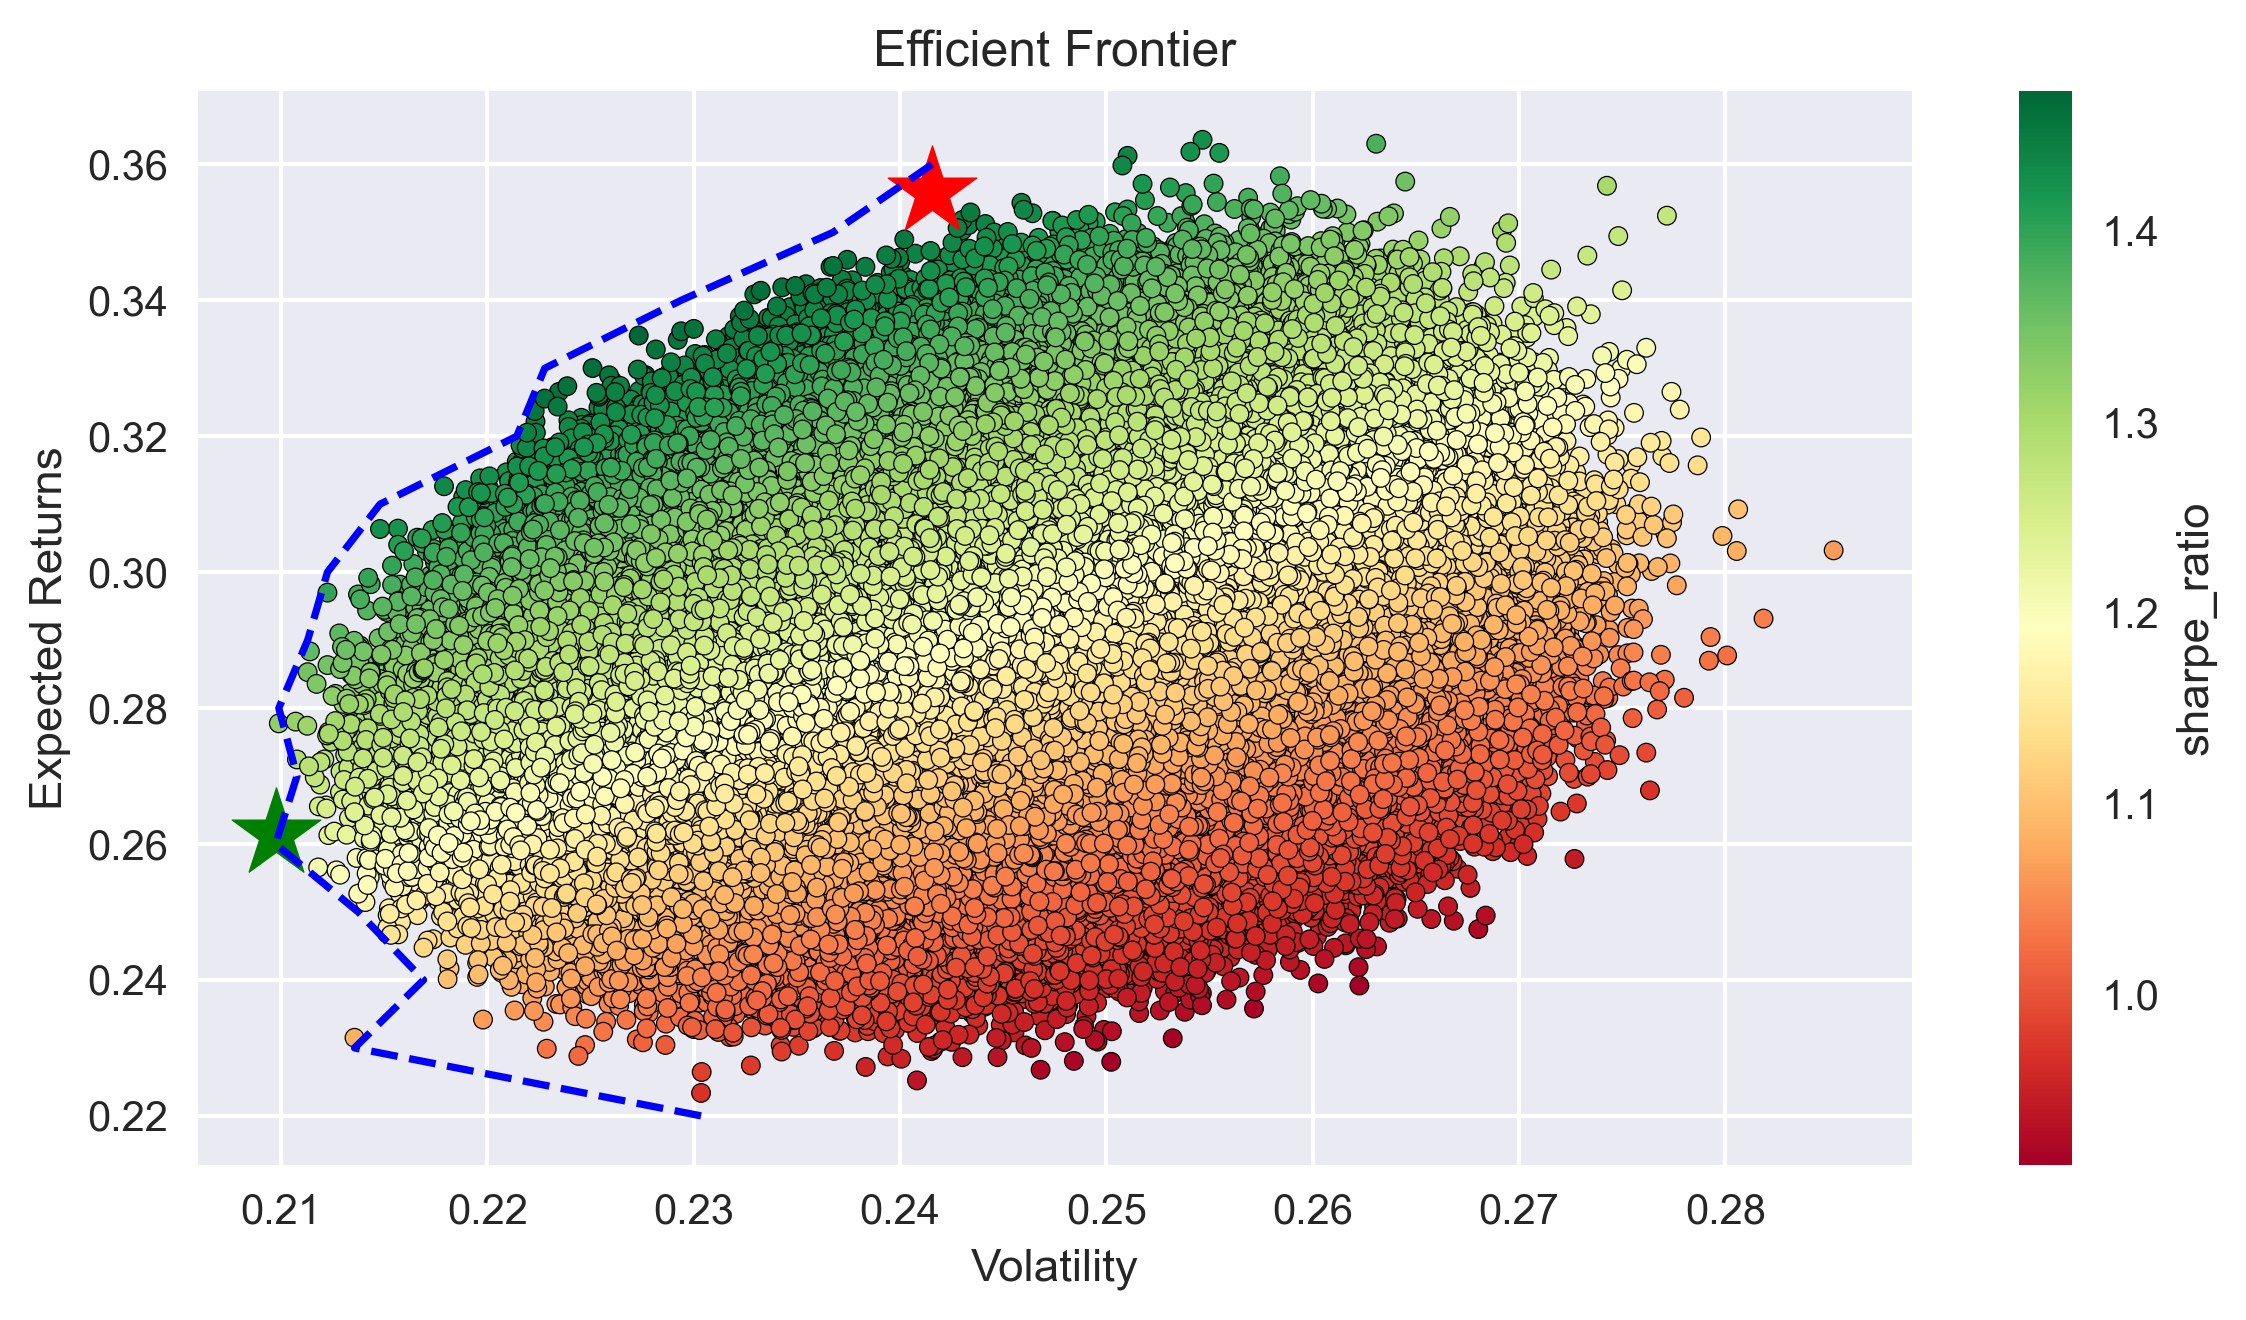

In [33]:
#Create scatter plot coloured by Sharpe Ratio
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                        y='returns', c='sharpe_ratio',
                        cmap='RdYlGn', edgecolors='black',
                        ax=ax)

ax.set(xlabel='Volatility',
        ylabel='Expected Returns',
        title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
ax.legend()

#plot red star to highlight position of portfolio with highest Sharpe Ratio
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns,
                c='red', marker='*', s=500)

#plot green star to highlight position of minimum variance portfolio
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns,
                c='green', marker='*', s=500)


plt.tight_layout()
plt.show()

In [34]:
import scipy.optimize as sco

In [35]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_rtns)
    args = (avg_rtns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [36]:
rtns_range = np.linspace(0.15, 0.45, 200)

efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [37]:
vols_range = [x['fun'] for x in efficient_portfolios]
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}
                                
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

portfolio2={}
print('\nWeights')
for x, y in zip(TICKERS, efficient_portfolios[min_vol_ind]['x']):
    # if y < 0.000001:
    #     continue
    portfolio2[x]=y
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 21.78% Volatility: 17.86% Sharpe Ratio: 122.00% 
Weights
AAPL: 0.00% ACN: 0.00% AMP: 0.00% AMT: 8.27% ARE: 10.93% ASGN: 0.00% ASIX: 0.00% BCO: 0.00% CBT: 0.00% CC: 0.00% CDNS: 0.00% CRM: 0.00% EBAY: 15.06% FIVE: 0.00% FN: 3.36% FR: 0.00% FTNT: 0.44% HOLX: 8.37% JBHT: 9.27% KIM: 0.00% MATX: 0.00% MHK: 0.00% NKE: 3.48% NVDA: 0.00% ON: 0.00% SPG: 0.00% STM: 0.00% TEL: 0.00% WDAY: 0.00% WM: 40.83% 

In [38]:
# import csv
with open('Portfolio 2.csv', 'w') as f:
    for key in portfolio2.keys():
        f.write("%s,%s\n"%(key,portfolio2[key]))

import pandas as pd
df = pd.read_csv('Portfolio 2.csv', header=None)
df.columns = ['Asset', 'Weight']
df.to_csv('Portfolio 2.csv', index=False)
# df.to_excel('Portfolio 2.xlsx', index=False)

In [39]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(N_ASSETS))
initial_guess = N_ASSETS * [1. / N_ASSETS]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [40]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
portfolio1 = {}
for x, y in zip(TICKERS, max_sharpe_portf_w):
    # if y < 0.000001:
    #     continue
    portfolio1[x]=y
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)
    

Maximum Sharpe Ratio portfolio ----
Performance
Return: 42.84% Volatility: 24.36% Sharpe Ratio: 175.83% 
Weights
AAPL: 16.96% ACN: 0.00% AMP: 0.00% AMT: 11.33% ARE: 0.00% ASGN: 0.00% ASIX: 0.00% BCO: 0.00% CBT: 0.00% CC: 0.00% CDNS: 12.29% CRM: 0.00% EBAY: 0.00% FIVE: 6.04% FN: 0.00% FR: 0.00% FTNT: 29.34% HOLX: 0.00% JBHT: 0.00% KIM: 0.00% MATX: 1.89% MHK: 0.00% NKE: 0.93% NVDA: 6.61% ON: 0.00% SPG: 0.00% STM: 0.00% TEL: 0.00% WDAY: 0.00% WM: 14.61% 

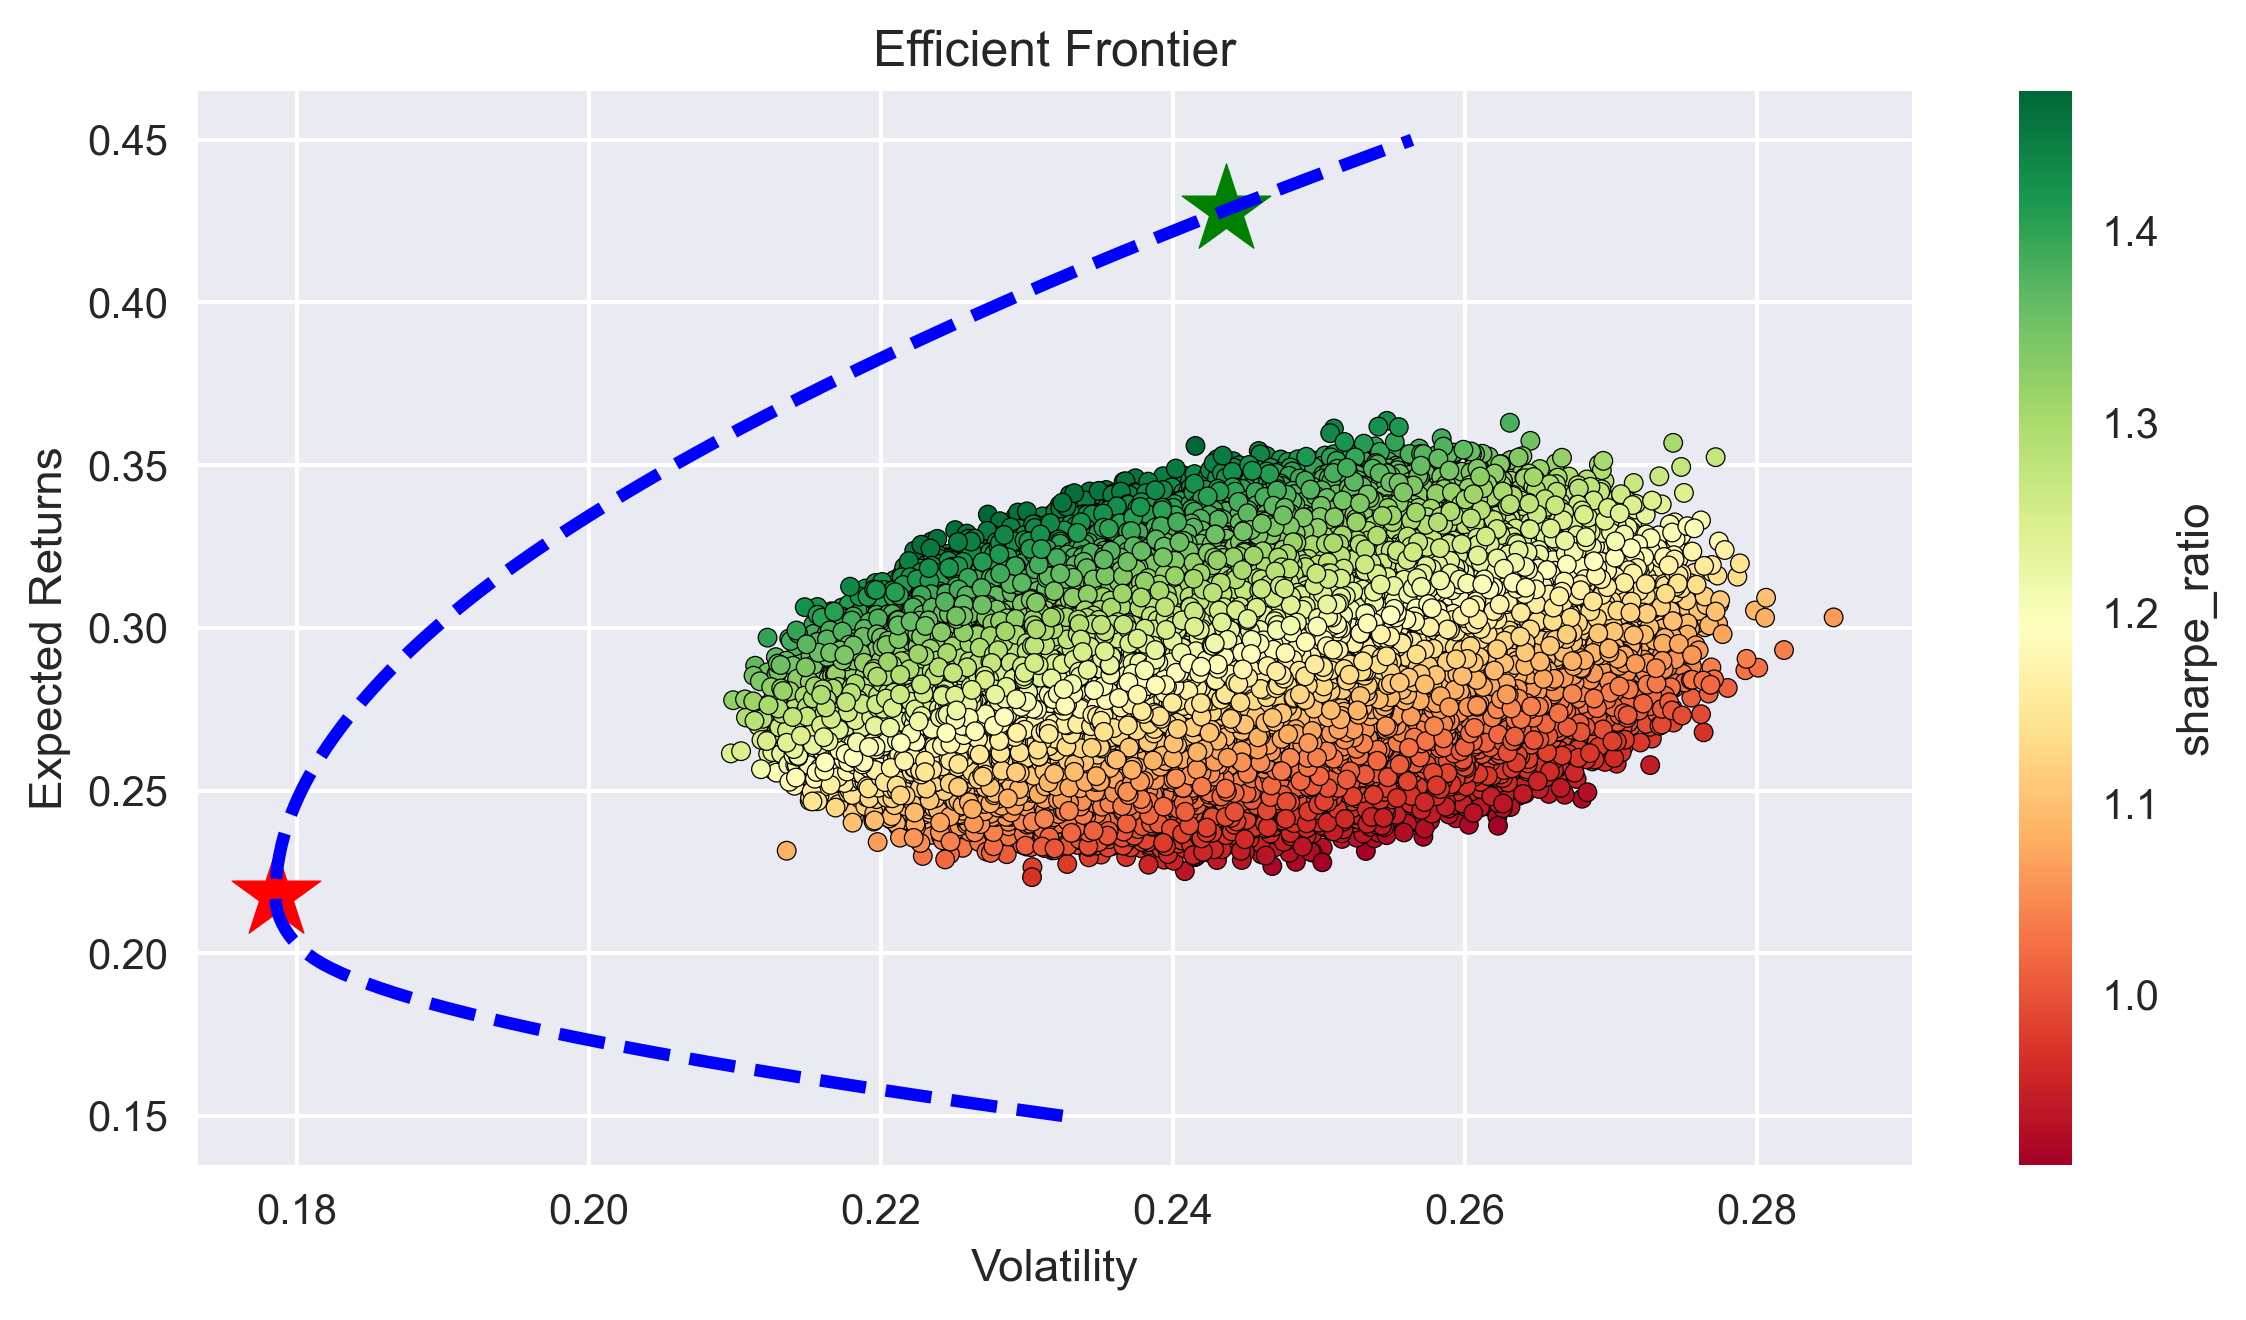

In [41]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

#plot red star to highlight position of portfolio with highest Sharpe Ratio
ax.scatter(x=max_sharpe_portf['Volatility'], y=max_sharpe_portf['Return'],
                c='green', marker='*', s=500)

#plot green star to highlight position of minimum variance portfolio
ax.scatter(x=min_vol_portf['Volatility'], y=min_vol_portf['Return'],
                c='red', marker='*', s=500)


plt.tight_layout()
# plt.savefig('images/ch7_im8.png')
plt.show()

In [42]:
# import csv
with open('Portfolio 1.csv', 'w') as f:
    for key in portfolio1.keys():
        f.write("%s,%s\n"%(key,portfolio1[key]))

import pandas as pd
df = pd.read_csv('Portfolio 1.csv', header=None)
df.columns = ['Asset', 'Weight']
df.to_csv('Portfolio 1.csv', index=False)
# df.to_excel('Portfolio 1.xlsx', index=False)

In [43]:
import pyfolio as pf
x = adj_close_df.pct_change().dropna()
y = max_sharpe_portf_w
# y = efficient_portfolios[min_vol_ind]['x']
z = x * y
c = z.sum(axis = 1)


In [44]:
#calculate beta against S&P 500
sp500_df = yf.download('^GSPC', start=START_DATE,
                       end=END_DATE, adjusted=True)
sp500_df = sp500_df['Adj Close'].pct_change().dropna()

#create a dataframe with the portfolio and S&P 500
beta_portfolio_df = pd.DataFrame({'Portfolio': c,
                                    'S&P 500': sp500_df})

#calculate correlation
corr = beta_portfolio_df.corr().iloc[0,1]
print(f'Correlation: {corr:.6f}')


# #calculate beta
covar = beta_portfolio_df.cov().iloc[0,1]
varSnP = beta_portfolio_df['S&P 500'].var()
beta = covar / varSnP
print(f'Beta: {beta:.6f}')

sharpe_portfolio = ((c.mean() - 0)/ c.std())*np.sqrt(252)
print("*****Sharpe Ratio of Portfolio**** :\n", sharpe_portfolio.round(4))

[*********************100%***********************]  1 of 1 completed
Correlation: 0.860837
Beta: 1.090211
*****Sharpe Ratio of Portfolio3**** :
 1.7583


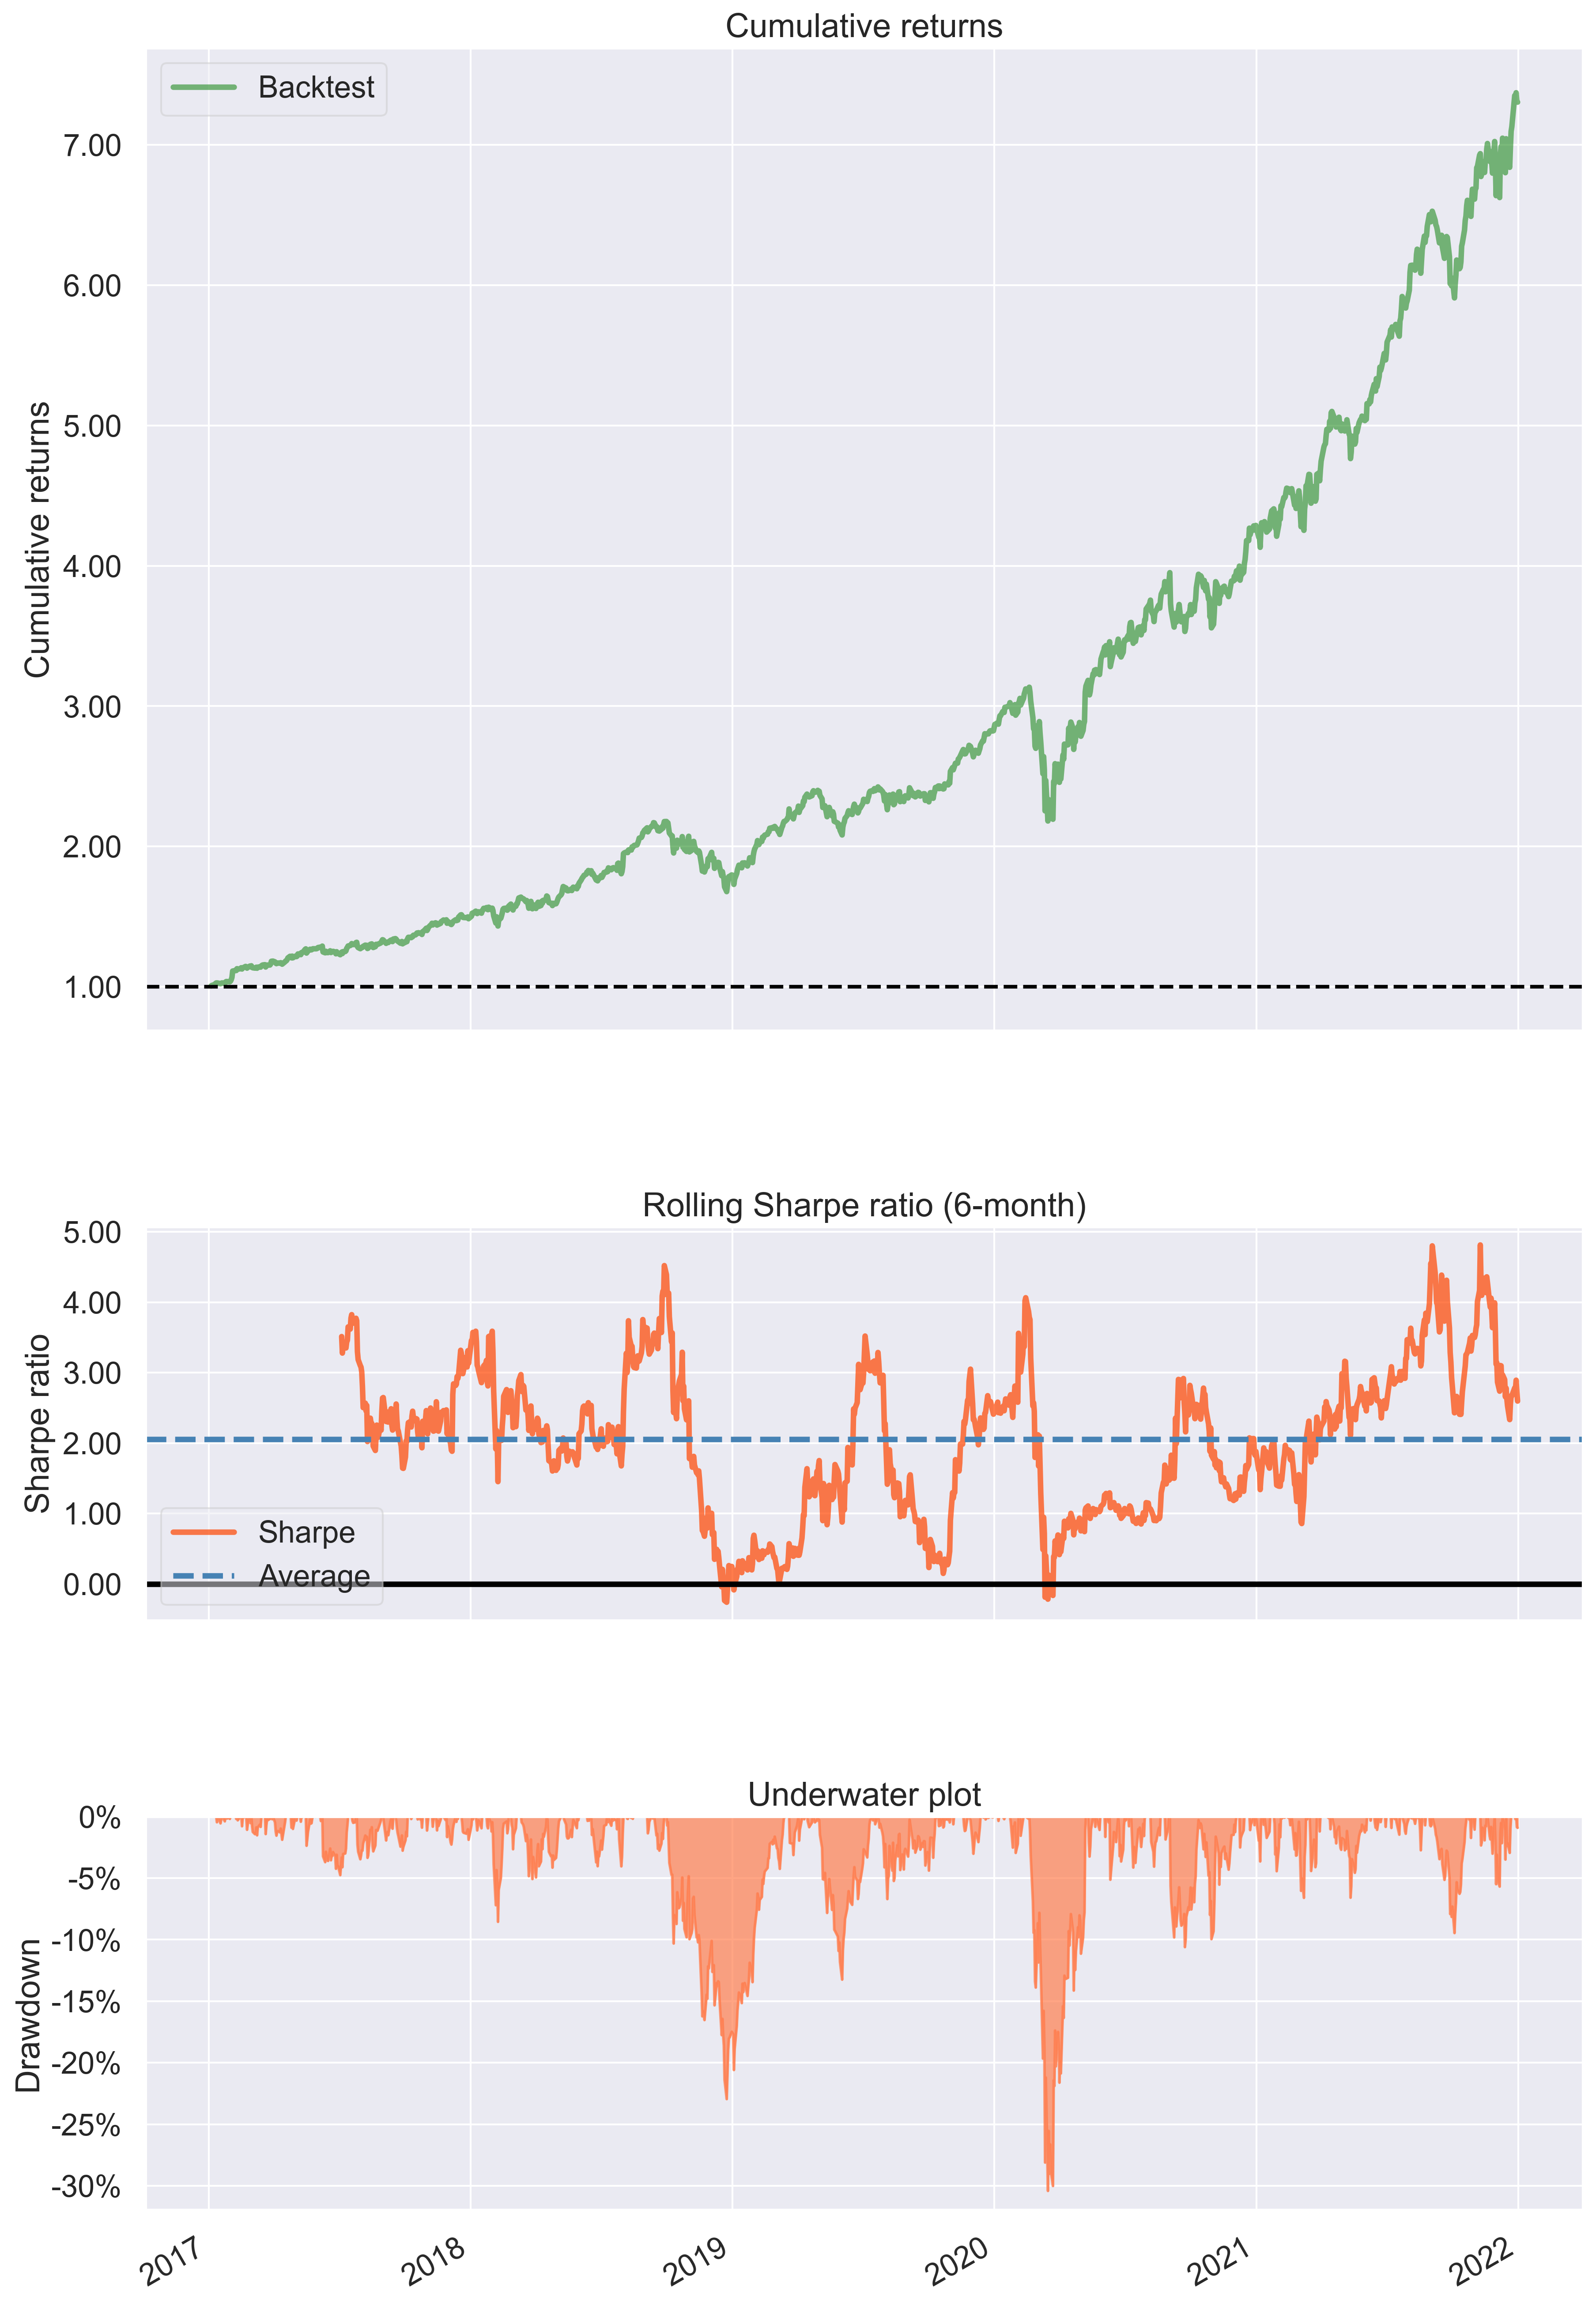

In [45]:
#plot the returns
# portfolio_returns_pyfolio.plot()

pf.create_simple_tear_sheet(c)

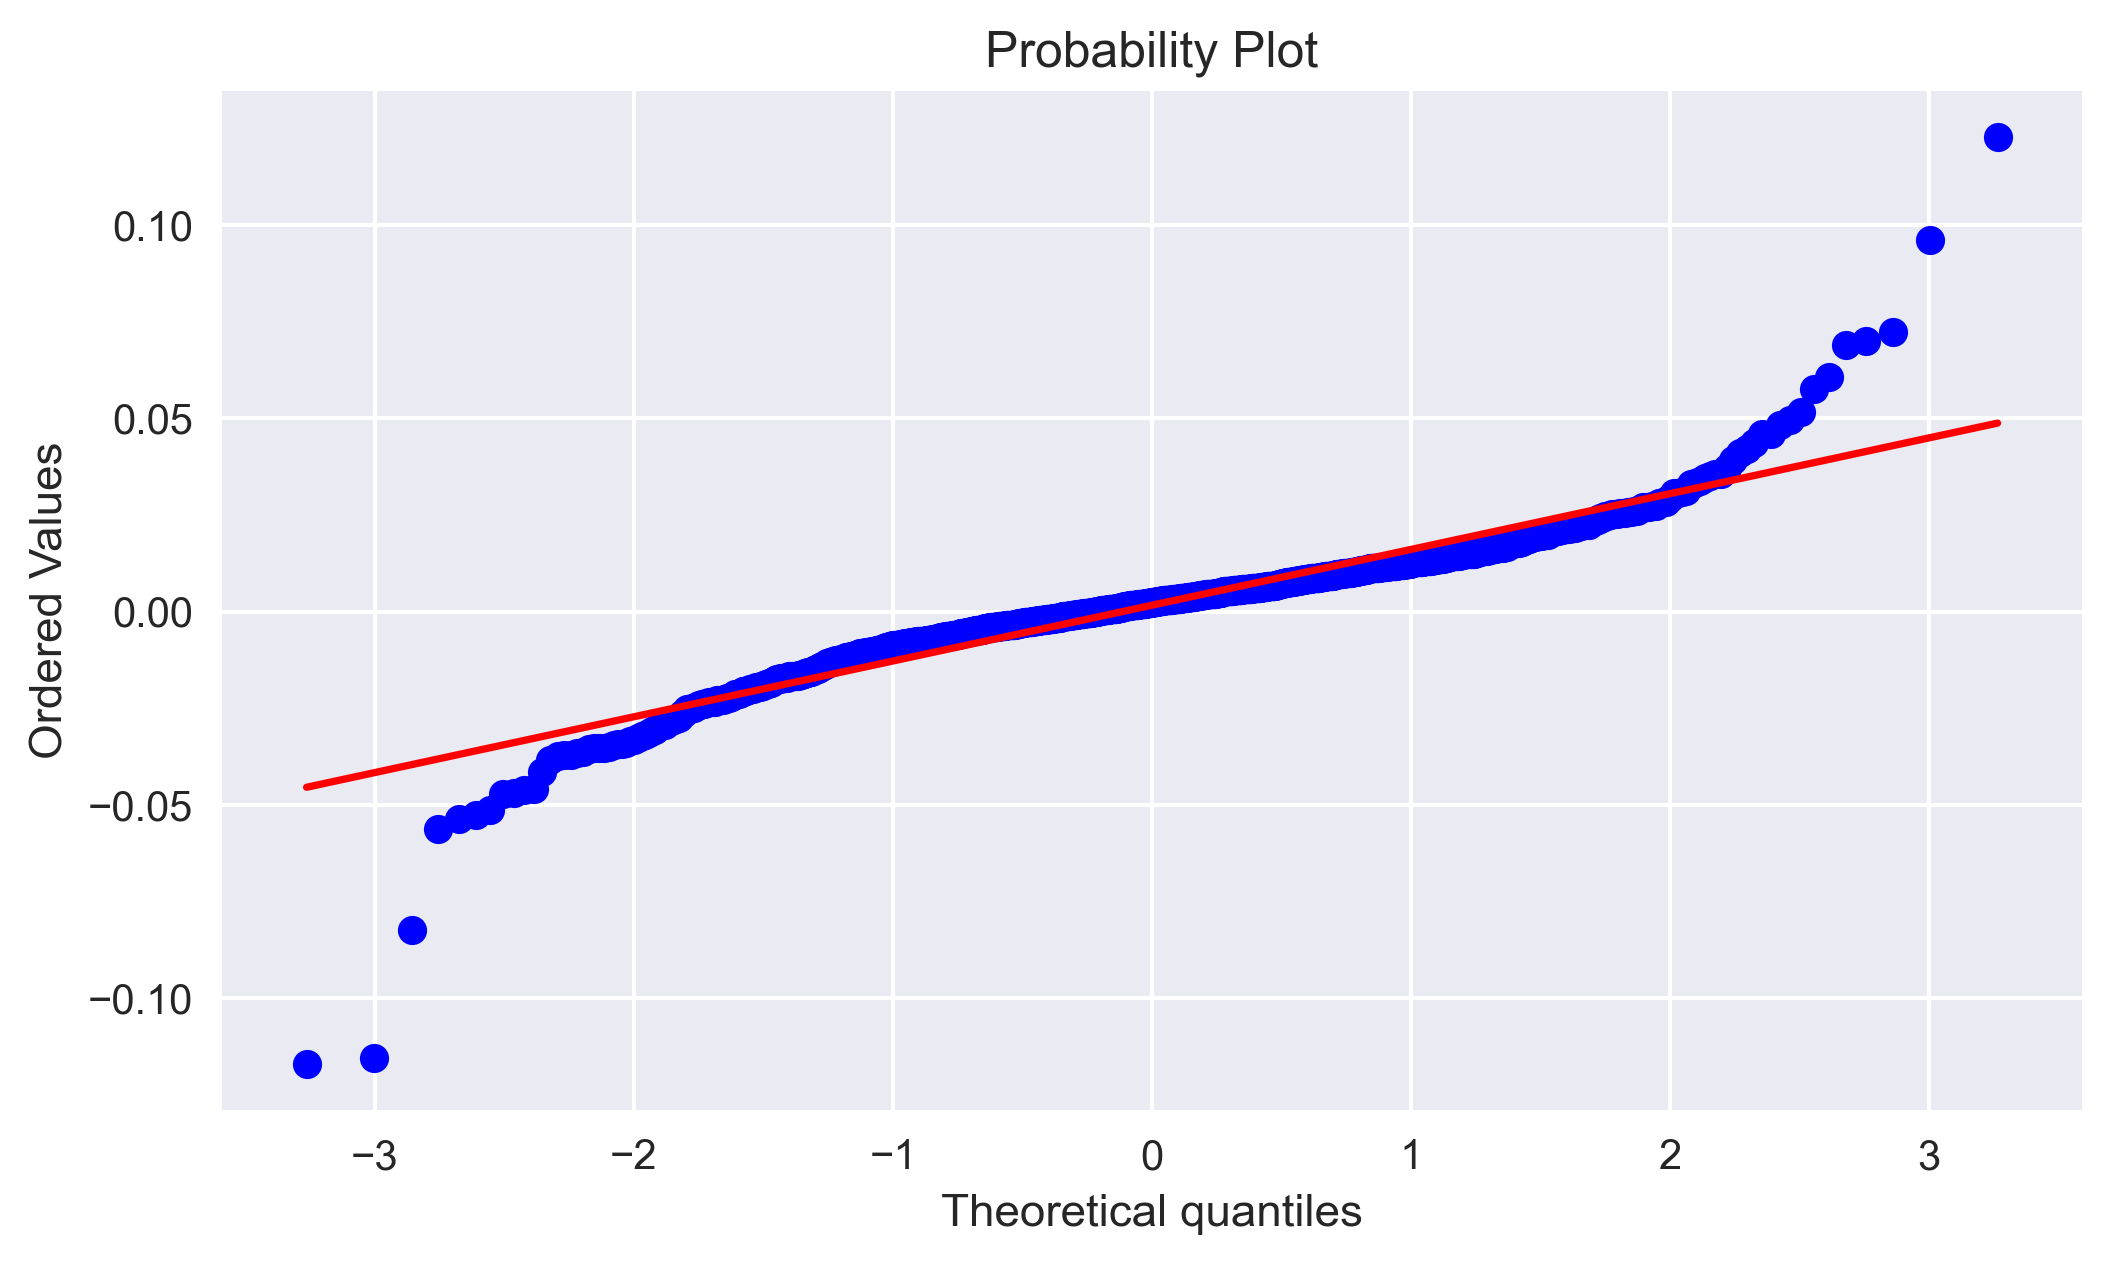

In [46]:
#Create qq plot for pct_change
import scipy.stats as stats
import pylab
stats.probplot(c, dist="norm", plot=pylab)
pylab.show()
